Please complete the `NotImplemented` parts of the code cells and write your answers in the markdown cells designated for your response to any questions asked. The tag `# AUTOGRADED` (all caps, with a space after `#`) should be at the beginning of each autograded code cell, so make sure that you do not change that. You are also not allowed to import any new package other than the ones already imported. Doing so will prevent the autograder from grading your code.

For the code submission, run the last cell in the notebook to create the submission zip file. If you are working in Colab, make sure to download and then upload a copy of the completed notebook itself to its working directory to be included in the zip file. Finally, submit the zip file to Gradescope.

After you finish the assignment and fill in your code and response where needed (all cells should have been run), save the notebook as a PDF using the `jupyter nbconvert --to pdf HW9.ipynb` command (via a notebook code cell or the command line directly) and submit the PDF to Gradescope under the PDF submission item. If you cannot get this to work locally, you can upload the notebook to Google Colab and create the PDF there. You can find the notebook containing the instruction for this on Canvas.

If you are running the notebook locally, make sure you have created a virtual environment (using `conda` for example) and have the proper packages installed. We are working with `python=3.10` and `torch>=2`.

Files to be included in submission:

- `HW9.ipynb`
- `model_config.yaml`
- `train_config.yaml`

# Implement and Train a Diffusion Model on MNIST

In [ ]:
from typing import Sequence, Tuple, Union
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams.update({'figure.autolayout': True})
from IPython.display import display, clear_output

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets
from torchvision.transforms import v2

if torch.cuda.is_available():
    Device = 'cuda'
elif torch.backends.mps.is_available():
    Device = 'mps'
else:
    Device = 'cpu'
print(f'Device is {Device}')

## Forward and Reverse Diffusion (25)

Your first task is to implement the forward and reverse diffusion process.

### Noise schedule
First we define a tensor containing $\beta_t$, $\alpha_t$, and $\bar{\alpha}_t$. Since the tensors will be used on batched data, you have to make their shapes broadcastable to a batch of data. Here is their relationship:
$$
\alpha_t = 1 - \beta_t
$$
$$
\bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s
$$
In the paper, the diffusion step range is $t=\{1, 2, ..., T\}$. However, since indexing starts from `0` in python, `t` will range from `0` to `T-1` in the code. We use `torch.cumprod` to obtain $\bar{\alpha}$ from $\alpha$.

### Forward diffusion (q)
You should implement the following for a batch of data $\mathbf{x}_0$ and their corresponding diffusion steps $t$:
$$
\mathbf{x}_t = (\sqrt{\bar{\alpha}_t})\mathbf{x}_0 + (\sqrt{1-\bar{\alpha}_t})\epsilon_q
$$
$$
\epsilon_q \sim N(\mathbf{0}, \mathbf{1})
$$
which samples from this distribution:
$$
q(\mathbf{x}_t|\mathbf{x}_0) = N\big(\sqrt{\bar{\alpha}_t}\mathbf{x}_0, (1-\bar{\alpha}_t)\mathbf{1}\big)
$$
Since each sample may have a different $t$, you should be careful with the shapes and make sure that broadcasting is done correctly. Also remember that $\epsilon_q$ should be of the same shape and device as the data.


### Reverse diffusion (p)
You should implement the following for a batch of corrupted data $\mathbf{x}_t$ and the diffusion step $t$:
$$
\mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon_\theta(\mathbf{x}_t, t) \right) + \sqrt{\beta_t} \epsilon_p
$$
$$
\epsilon_p =
\begin{cases}
    0 & t = 1 \space (\text{0 in python})\\
    \sim N(\mathbf{0}, \mathbf{1})  & t > 1
\end{cases}
$$

which samples from this distribution (except the final denoising step with $t=1$ which is deterministic):
$$
p_\theta(\mathbf{x}_{t-1} | \mathbf{x}_t) = N\Big(\frac{1}{\sqrt{\alpha_t}} \big(\mathbf{x}_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon_\theta(\mathbf{x}_t, t)\big), \beta_t\mathbf{1}\Big)
$$

Here, $\epsilon_\theta(\mathbf{x}_t, t)$ is the output of the neural network that is trained to estimate the noise from the forward diffusion ($\epsilon_q$). Again, remember that indexing starts from `0` in python.

In [ ]:
class Diffusion(nn.Module):

    def __init__(
        self,
        T: int = 1000, # total number of diffusion steps,
        b_0: float = 1e-4,
        b_T: float = 2e-2,
        n_data_dims: int = 3, # number of data dimensions. For example, colored image data has 3 (channel, height, width)
        ):
        super().__init__()
        self.T = T

        # calculate the 1D tensor for beta containing the values for each diffusion step
        # using quadratic schedule
        beta = torch.linspace(b_0**0.5, b_T**0.5, T)**2

        # based on n_data_dims, make the shape of beta broadcastable to batched data
        NotImplemented
            
        # calculate alpha and alpha_bar from beta
        # both alpha and alpha_bar have T elements as well, one for each diffusion step
        alpha = 1. - beta
        alpha_bar = alpha.cumprod(dim=0)

        # register the tensors as buffers to be saved with the model
        # and to be moved to the right device when calling .to(device)
        # You can access them like a normal attribute, like self.alpha
        self.register_buffer('alpha', alpha)
        self.register_buffer('alpha_bar', alpha_bar)
        self.register_buffer('beta', beta)

    @torch.no_grad()
    def forward(
            self,
            x_0: torch.FloatTensor, # (batch_size, *data_shape),
            t: torch.LongTensor, # (batch_size,),
            )-> Tuple[torch.FloatTensor, torch.FloatTensor]: # noisy data and the epsilon used to corrupt it
        """
        for each data sample in the batch, draw a sample from q(x_t|x_0, t)
        according to the schedule and the corresponding diffusion step of each data sample.

        You can index alpha, alpha_bar, or beta with the tensor t directly,
        and get a batch of alpha, alpha_bar, or beta values.

        Returns:
        x_t: torch.FloatTensor, the corrupted batch
        eps_q: torch.FloatTensor, the noise used to corrupt the data
        """
        
        # mean of q(x_t|x_0, t)
        mu = NotImplemented

        # std of q(x_t|x_0, t)
        std = NotImplemented

        # sample from q using the reparameterization trick
        eps_q = NotImplemented
        x_t = NotImplemented

        return x_t, eps_q
    
    @torch.inference_mode()
    def reverse(
            self,
            x_t: torch.FloatTensor, # (batch_size, *data_shape),
            t: int,
            eps_theta: torch.FloatTensor, # (batch_size, *data_shape),
            ):
        """
        for a batch of corrupted data x_t and using the estimated noise eps_theta, 
        sample from p(x_{t-1}|x_t, t)
        
        Here, t is the same for all samples in the batch.

        Returns:
        x_t_1: torch.FloatTensor, a single-step denoised batch of data
        """

        # mean of p(x_{t-1}|x_t, t)
        mu = NotImplemented

        # std of p(x_{t-1}|x_t, t)
        std = NotImplemented

        # sample from p using the reparameterization trick
        # NOTE: no noise is added at the final denoising step (t=0 -> eps_p=0)
        eps_p = NotImplemented
        x_t_1 = NotImplemented

        return x_t_1

## Model Architecture (50)

The neural network of a diffusion model is trained to estimate the noise that was used in the forward diffusion. It takes the noisy data (which has been corrupted with noise according to the noise schedule) and the diffusion step explicitly. Your model should be a U-Net (review week 7 for a refresher on U-Net). The diffusion step $t$ should be embedded, and incorporated at every stage of the U-Net by a distinct feedforward network. Follow the instructions given in the comments. You can see the architecture of the [original U-Net](https://arxiv.org/pdf/1505.04597) below. Our U-Net has a similar architecture, with the addition of the embedder and encoders for the diffusion step. The shape of the data is also different, and no cropping is done in the skip connections. We will use average pooling for the downsampling, and an arbitrary choice of activation and hidden channels.

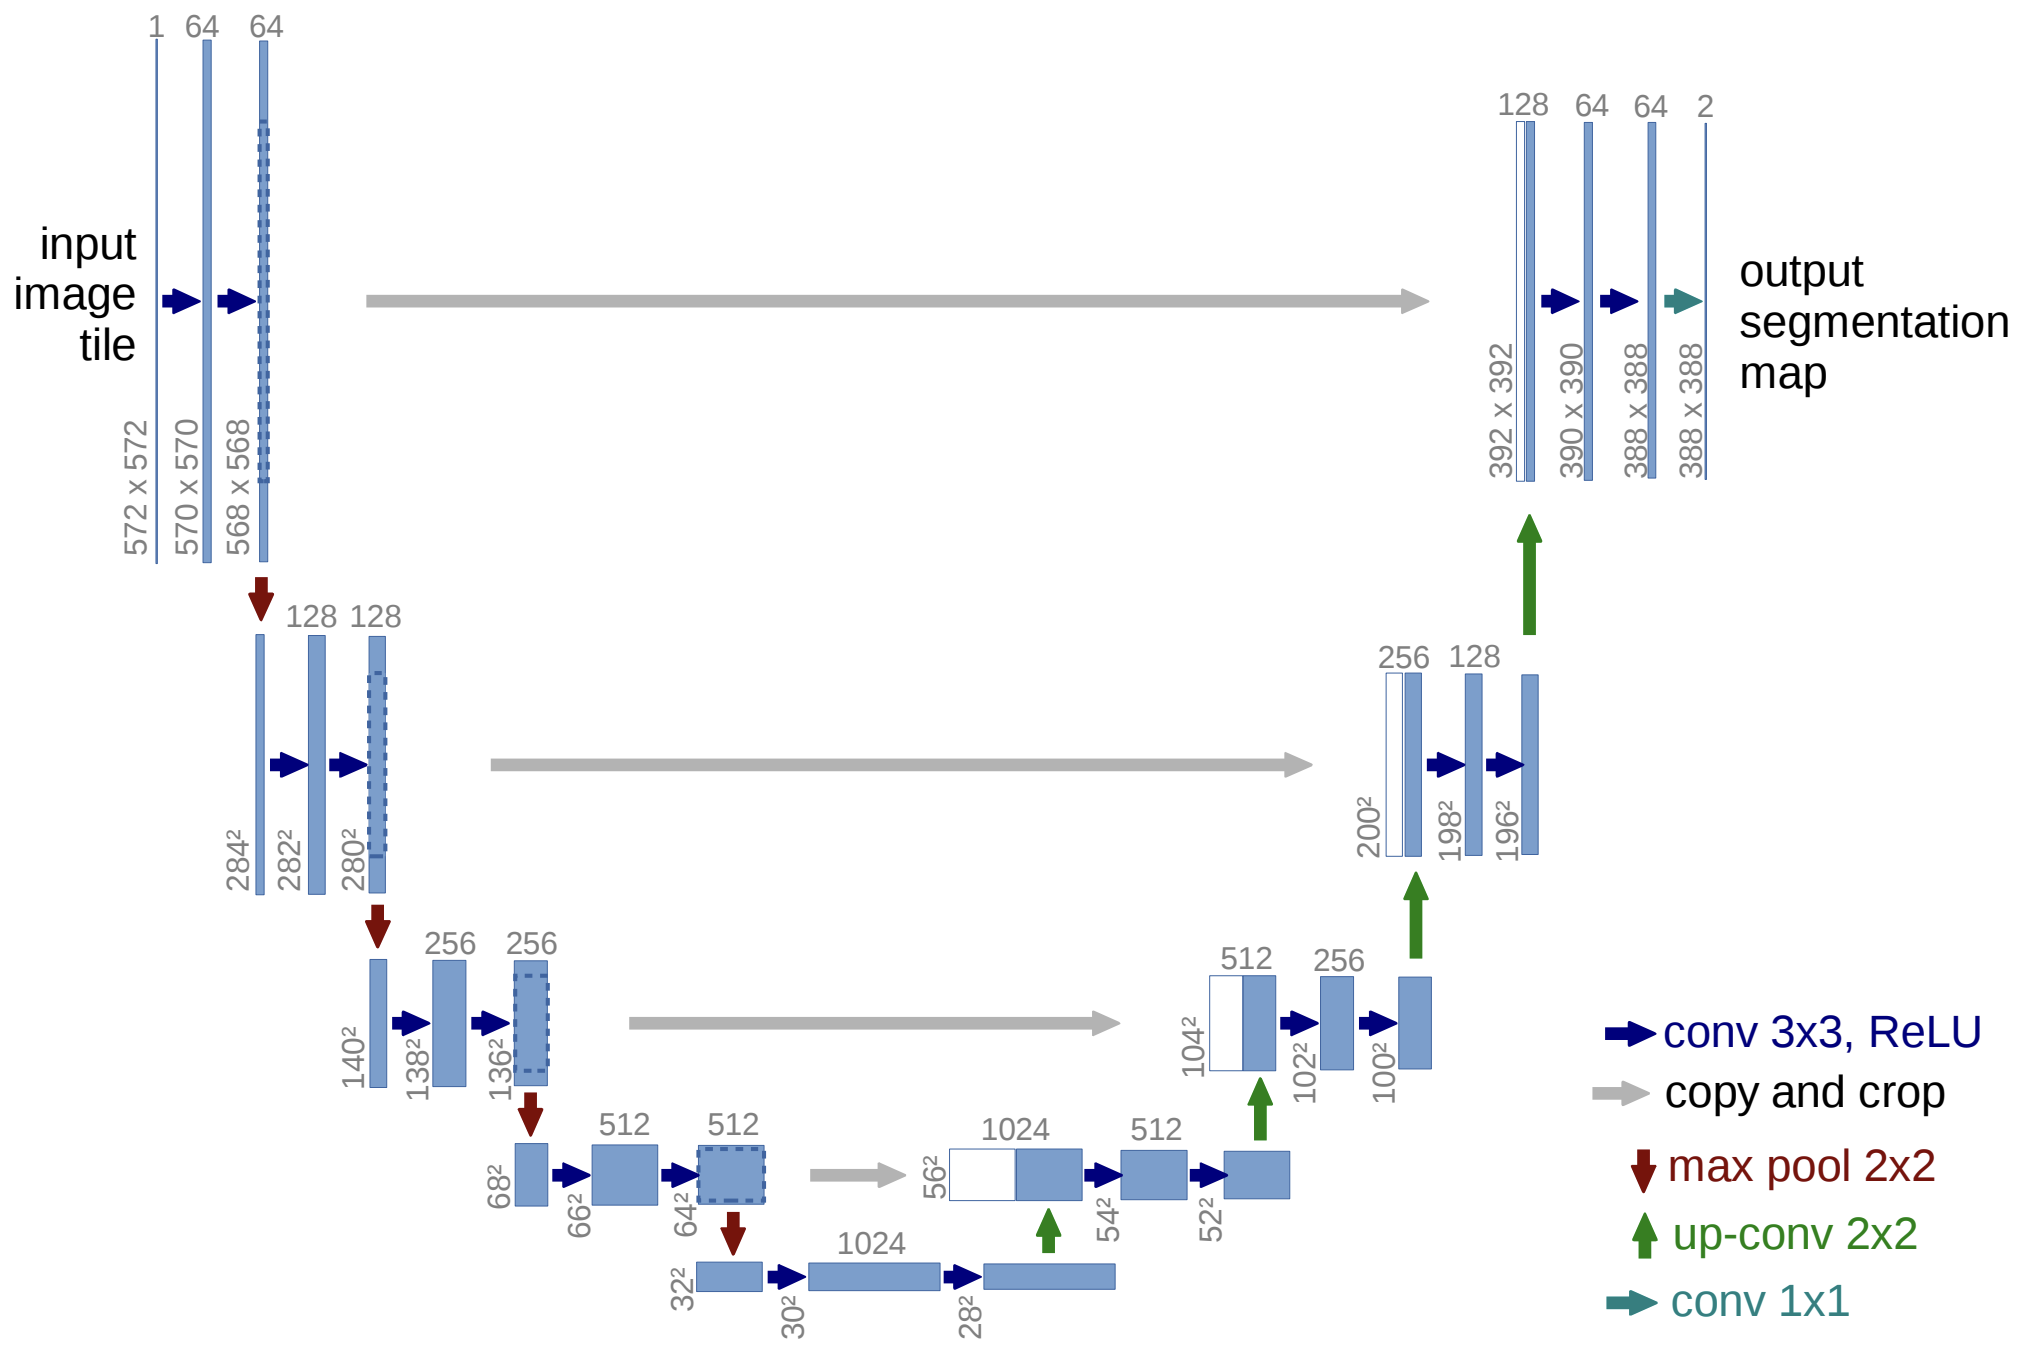

In [ ]:
class ConvBlock(nn.Module):
    """
    a module in the contracting path of the U-Net.
    simply consists of a series of conv, batchnorm, and activation layers.
    """
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            activation_name: str = 'ReLU',
            n_layers: int = 2,
            batchnorm: bool = False,
            ):
        super().__init__()
        activation = nn.__getattribute__(activation_name)
        self.layers = nn.Sequential()
        for i in range(n_layers):
            self.layers.append(
                nn.Conv2d(
                    in_channels = in_channels if i == 0 else out_channels,
                    out_channels = out_channels,
                    kernel_size = 3,
                    stride = 1,
                    padding = 'same',
                ))
            if batchnorm:
                self.layers.append(nn.BatchNorm2d(out_channels))
            self.layers.append(activation())

    def forward(
            self,
            x: torch.FloatTensor,
            )-> torch.FloatTensor:

        return self.layers(x)
    

class UpBlock(nn.Module):
    """
    a module in the expanding path of the U-Net.
    First, the input to the block is upconved and concatenated with the skip connection.
    Then, a series of conv, batchnorm, and activation layers are applied.
    """
    def __init__(
            self,
            in_channels: int,
            skip_channels: int,
            out_channels: int,
            activation_name: str = 'ReLU',
            n_layers: int = 2,
            batchnorm: bool = False,
            ):
        super().__init__()

        self.up = nn.ConvTranspose2d(
            in_channels = in_channels,
            out_channels = out_channels,
            kernel_size = 2,
            stride = 2,
            padding = 0,
            )
        
        self.layers = ConvBlock(
            in_channels = out_channels + skip_channels,
            out_channels = out_channels,
            activation_name = activation_name,
            n_layers = n_layers,
            batchnorm = batchnorm,
            )

    def forward(
            self,
            x: torch.FloatTensor,
            skip: torch.FloatTensor,
            )-> torch.FloatTensor:

        # upconv x
        x = self.up(x)
        
        # concatenate the output with the skip connection
        x = torch.cat([skip, x], dim=1)

        # pass x through the main block and return the result
        return self.layers(x)


class FeedForward(nn.Module):
    """
    A simple feedforward neural network to decode the embedded diffusion step in each stage.
    """
    def __init__(
            self,
            in_features: int,
            out_features: int,
            hidden_sizes: Sequence[int],
            activation_name: str = 'ReLU',
            ):
        super().__init__()
        activation = nn.__getattribute__(activation_name)
        n_layers = len(hidden_sizes)
        self.layers = nn.Sequential()
        for i in range(n_layers):
            self.layers.append(
                nn.Linear(
                    in_features = in_features if i == 0 else hidden_sizes[i-1],
                    out_features = hidden_sizes[i],
                    ))
            self.layers.append(activation())

        self.layers.append(
            nn.Linear(
                in_features = hidden_sizes[-1],
                out_features = out_features,
                ))

    def forward(
            self,
            x: torch.FloatTensor, # (batch_size, in_features)
            )-> torch.FloatTensor: # (batch_size, out_features, 1, 1)
        """
        The output is going to be added to data of shape (B, C, H, W)
        where C = out_features,
        So it has to be broadcastable to the same shape.
        """
        return self.layers(x)[..., None, None]
        

class Model(nn.Module):

    """
    A U-Net with a corresponding diffusion step decoder for each block.
    """
    def __init__(
            self,
            data_shape: Sequence[int] = [1, 32, 32],

            # diffusion parameters
            T: int = 1000,
            b_0: float = 1e-4,
            b_T: float = 2e-2,

            # diffusion step embedding
            t_embed_dim: int = 128,

            # U-Net architecture
            channels: Sequence[int] = [16, 32, 64, 128],
            n_block_layers: int = 2,
            activation_name: str = 'ReLU',
            batchnorm: bool = False,
            ):
        super().__init__()  

        # to be used for data generation
        self.data_shape = data_shape

        # ======================= Diffusion ==========================

        self.diffusion = Diffusion(
            T = T,
            b_0 = b_0,
            b_T = b_T,
            n_data_dims = len(data_shape),
            )

        # =========================== Model ===========================

        n_layers = len(channels)
        self.n_layers = n_layers
        
        self.blocks = nn.ModuleDict()

        self.t_emebdder = nn.Embedding(
            num_embeddings = T,
            embedding_dim = t_embed_dim,
            )

        self.t_decoder = nn.ModuleDict()
        # An encoder should be assigned to the output of each block in
        # the contracting path or the expanding path.
        # Each encoder takes as input the embedded diffusion step.

        # contracting path
        for i in range(n_layers):
            # example for 4 layers:
            # down_0, down_1, down_2, down_3
            self.blocks[f'down_{i}'] = NotImplemented
            
            # the output of the t_encoder will be added to the output of the block
            self.t_decoder[f'down_{i}'] = NotImplemented
            
        # expanding path (reverse depth)
        for i in range(n_layers-2, -1, -1):
            # example for 4 layers:
            # up_2, up_1, up_0

            self.blocks[f'up_{i}'] = NotImplemented
            
            # the output of the t_encoder will be added to the output of the block
            self.t_decoder[f'up_{i}'] = NotImplemented
            
        # final output layer to get the estimated noise tensor
        # the output should have the same shape as the input data
        # use kernel_size = 1, stride = 1, padding = 0
        self.out = NotImplemented


    def forward(
            self,
            x: torch.FloatTensor, # (batch_size, *data_shape)
            t: Union[int, torch.LongTensor], # (batch_size,)
            ) -> torch.FloatTensor: # (batch_size, *data_shape)
        """
        Inputs:
            x: a batch of corrputed data
            t: the corresponding diffusion step for each sample in the batch

        returns:
            eps_theta: the estimated noise tensor used to corrupt the data in the forward diffusion.
        """

        if isinstance(t, int):
            # create a LongTensor of shape (batch_size,) from t, on the same device as x_0
            t = torch.tensor(len(x)*[t], device=x.device, dtype=torch.long)

        # embed the diffusion step
        t_embedded = self.t_emebdder(t)

        # to store the skip connections
        skips = []

        # contracting path
        for i in range(self.n_layers):

            # pass data through the block
            NotImplemented

            # append the result to skips, to be used in the expanding path
            # except for the last down block (deepest layer)
            NotImplemented

            # encode t_embedded with the corresponding decoder
            # and add it channel-wise to data
            NotImplemented

            # downsample data with F.avg_pool2d and kernel_size=2
            # except for the last down block (deepest layer)
            NotImplemented
                

        # expanding path (reverse depth)
        for i in range(self.n_layers-2, -1, -1):

            # pass the data and the corresponding skip connection to the block
            NotImplemented

            # encode t_embedded with the corresponding decoder
            # and add it channel-wise to the data
            NotImplemented

        # pass data through the final convolutional layer
        eps_theta = NotImplemented

        return eps_theta


    @torch.inference_mode()
    def generate(
        self,
        n_samples: int,
        device: str = Device,
        )-> torch.FloatTensor: # (n_samples, *data_shape):
        """
        Sample a noise tensor of the right shape and device.
        Execute the reverse diffusion process using the model.

        Returns:
           xs of shape (T, n_samples, *data_shape)
           the full batch of denoised samples at each diffusion step
           starting from pure noise and ending with the final generated samples.
        """
        self.eval().to(device)

        # start from pure noise of the right shape and device
        x = NotImplemented

        # for the sake of visualization, we will store the data throughout reverse diffusion
        xs = [x]

        # denoise step-by-step by sampling from p(x_{t-1}|x_t, t)
        # t = T-1, T-2, ..., 1, 0
        for t in range(self.diffusion.T-1, -1, -1):
            
            # get the model output
            NotImplemented

            # do one step of reverse diffusion
            NotImplemented

            # append the denoised data to xs
            NotImplemented

        return torch.stack(xs)

## Tracking and visualization

In [ ]:
class Diffusion_Tracker:
    """
    Logs and plots different loss terms of a GAN during training.
    """
    def __init__(
            self, 
            n_iters: int,
            plot_freq: Union[int, None] = None, # plot every plot_freq iterations
            ):
        
        self.losses = []

        self.plot = plot_freq is not None
        self.iter = 0
        self.n_iters = n_iters
		
        if self.plot:
            self.plot_freq = plot_freq
            self.plot_results()


    def plot_results(self):
        self.fig, self.ax = plt.subplots(figsize=(12, 4))

        # Score plot:
        self.loss_curve, = self.ax.plot(
            range(1, self.iter+1),
            self.losses,
            )

        self.ax.set_xlim(0, self.n_iters+1)
        self.ax.set_ylim(0, 1)
        self.ax.set_xlabel('Iteration')
        self.ax.set_ylabel('Loss')
        self.ax.set_title('Diffusion Learning Curve')
        self.ax.grid(linestyle='--')

        self.samples_fig, self.samples_axes = plt.subplots(5, 8, figsize=(8, 5), sharex=True, sharey=True)
        self.sample_axes = self.samples_axes.flat
        self.samples = []
        for ax in self.sample_axes:
            ax.axis('off')
            self.samples.append(ax.imshow(np.zeros((32, 32)), cmap='gray', vmin=0, vmax=1))


    def update(
            self, 
            loss: float,
            ):
        self.losses.append(loss)
        self.iter += 1
		
        if self.plot and self.iter % self.plot_freq == 0:

            # score plot:
            self.loss_curve.set_data(range(1, self.iter+1), self.losses)
            self.ax.relim()
            self.ax.autoscale_view()

            self.samples_fig.suptitle(f'Generated Samples at Iteration {self.iter}')

            self.fig.canvas.draw()
            clear_output(wait=True)
            display(self.fig)
            display(self.samples_fig)

    
    def get_samples(
            self, 
            samples: torch.FloatTensor, # (n_samples, *output_shape)
            ):
        for sample, sample_img in zip(samples, self.samples):
            sample_img.set_data(sample.clip(0, 1).detach().squeeze().cpu().numpy())
            

## Training (10)

In [ ]:
@torch.enable_grad()
def train(
        model: Model,
        train_dataset: Dataset,
        device = Device,
        plot_freq: int = 100,

        optimizer_name: str = 'Adam',
        optimizer_config: dict = dict(),
        lr_scheduler_name: Union[str, None] = None,
        lr_scheduler_config: dict = dict(),

        n_iters: int = 5000,
        batch_size: int = 32,
        ):

    model.train().to(device)

    tracker = Diffusion_Tracker(
        n_iters = n_iters, 
        plot_freq = plot_freq,
        )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    optimizer: optim.Optimizer = optim.__getattribute__(optimizer_name)(model.parameters(), **optimizer_config)
    if lr_scheduler_name is not None:
        lr_scheduler: optim.lr_scheduler._LRScheduler = optim.lr_scheduler.__getattribute__(lr_scheduler_name)(optimizer, **lr_scheduler_config)

    iter = 0
    iter_pbar = tqdm(range(n_iters), desc='Iters', unit='iter', leave=True)

    while iter < n_iters:

        for x, _ in train_loader:

            model.train()

            x = x.to(device)
            
            # sample a random diffusion step for each sample in the batch
            NotImplemented

            # forward diffusion
            NotImplemented

            # model's forward pass
            NotImplemented

            # calculate the loss
            loss = NotImplemented

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
            if lr_scheduler_name == 'ReduceLROnPlateau':
                lr_scheduler.step(loss.item())
            elif lr_scheduler_name is not None:
                lr_scheduler.step()

            # ==================== Logging ====================
            iter += 1
            iter_pbar.update(1)
            iter_pbar.set_postfix_str(f'loss: {loss.item():.6f}')
            if iter % plot_freq == 0:
                gen_samples = model.generate(40)[-1]
                tracker.get_samples(gen_samples)
            tracker.update(loss.item())
            if iter >= n_iters:
                break

## Dataset

In [ ]:
train_dataset = datasets.MNIST(
    root = 'MNIST',
    train = True,
    download = True,
    # transform the data to torch.Tensor and scale it to [0, 1]
    transform = v2.Compose([
        # convert to tensor and scale to [0, 1]
        v2.ToImage(),
        v2.Pad(2), # to make the images 32x32
        v2.ToDtype(torch.float32, scale=True),
    ])
    )

## Find and train a good model (15)

Your grade will depend on the quality and diversity of your generated samples. If almost all your samples are nice, you will get full points. Diffusion models take some time to train. While your loss may not seem to improve, your sample quality might improve with more training, so be parient.

In [ ]:
# YOUR CODE

model_config = dict(
    # diffusion parameters (we suggest to not change these)
    T = 1000,
    b_0 = 1e-4,
    b_T = 2e-2,

    # model parameters
    t_embed_dim = NotImplemented,
    channels = NotImplemented,
    n_block_layers = NotImplemented,
    activation_name = NotImplemented,
    batchnorm = NotImplemented,
    )

train_config = dict(
    optimizer_name = NotImplemented,
    optimizer_config = NotImplemented,
    lr_scheduler_name = NotImplemented,
    lr_scheduler_config = NotImplemented,
    
    n_iters = NotImplemented,
    batch_size = NotImplemented,
    )

In [ ]:
if __name__ == '__main__':
    model = Model(
        data_shape = [1, 32, 32],
        **model_config,
        )
    train(
        model = model, 
        train_dataset = train_dataset, 
        device = Device,
        plot_freq = 500,
        **train_config,
        )

## Visualize reverse diffusion

In [ ]:
gen_samples = model.generate(10)

def plot_reverse_diffusion(
        xs: torch.FloatTensor, # (T+1, n_samples, *data_shape)
        n_steps: int = 10,
        ):
    n_samples = xs.shape[1]
    ts = list(range(0, model.diffusion.T+1, model.diffusion.T//n_steps))
    fig, axes = plt.subplots(n_samples, n_steps+1, figsize=(8, 8), sharex=True, sharey=True)
    for sample_idx, ax in enumerate(axes):
        for t_idx, a in enumerate(ax):
            a.axis('off')
            a.imshow(xs[ts[t_idx], sample_idx].squeeze().detach().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
            if sample_idx == 0:
                a.set_title(f't={model.diffusion.T-ts[t_idx]}')
    plt.tight_layout()
    plt.show()

plot_reverse_diffusion(gen_samples, n_steps=10)


## Zip files for submission

In [ ]:
import os
import yaml
import zipfile

def save_yaml(config: dict, path: str):
    with open(path, 'w') as f:
        yaml.dump(config, f, sort_keys=False, default_flow_style=None)


def zip_files(output_filename: str, file_paths: list):
    with zipfile.ZipFile(output_filename, 'w') as zipf:
        for file_path in file_paths:
            zipf.write(file_path, os.path.basename(file_path))


save_yaml(model_config, 'model_config.yaml')
save_yaml(train_config, 'train_config.yaml')

submission_files = ['HW9.ipynb', 'model_config.yaml', 'train_config.yaml']
zip_files('HW9_submission.zip', submission_files)